In [209]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import os
import glob

import pandas as pd

from scipy.optimize import least_squares

working_dir=r"C:\Users\Experience\Desktop\CalibrationOfWavePlates\KBDproject\KBDproject\bin\x64\Debug\Data"
folder='\Arya_hwp20220503122621'

os.chdir(working_dir+folder)
working_dir+=folder+'\\'

In [210]:
filenames = [i for i in glob.glob("*.txt")]
filenames.sort(key=os.path.getmtime)

control=[]
meas=[]

for i, string in enumerate(filenames):
    if string.find("Control")>0:
        control.append(string)
    else:
        meas.append(string)

counts=np.zeros(len(meas), dtype=float)
counts_err=np.zeros(len(meas), dtype=float)
control_data=np.zeros(len(control), dtype=float)
control_data_err=np.zeros(len(control), dtype=float)

for i, string in enumerate(meas):
    df = np.loadtxt(working_dir+str(string))
    counts[i] = df
    counts_err[i] = np.sqrt(df)
    
for i, string in enumerate(control):
    df = np.loadtxt(working_dir+str(string))
    control_data[i] = df
    control_data_err[i] = np.sqrt(df)

In [211]:
offset=356
step=2
interval=[-90,90.1]
angles=np.arange(interval[0], interval[1], step)
angles_plot=angles+np.full(len(angles), offset)

Text(0, 0.5, 'Control counts')

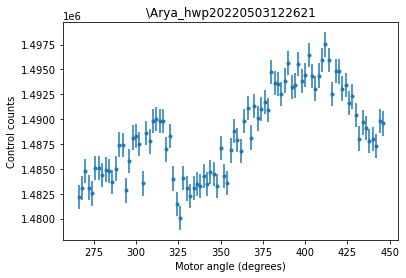

In [212]:
plt.errorbar(angles_plot, control_data, control_data_err, fmt='.')
plt.title(folder)
plt.xlabel("Motor angle (degrees)")
plt.ylabel("Control counts")

In [213]:
##Defining the fiiting functions

#Considering perfect input states:
def qwp_p(x, A, phi, B):
    #q=A*(3+np.cos(4*np.pi*(x-phi)/180)+B)/4 #Input polarization PARALEL to WPS
    q=A*(2*(np.cos(np.pi*(x-phi)/180)**2)*(np.sin(np.pi*(x-phi)/180))**2+B)#Input polarization PERPENDICULAR to WPS
    return q
 
def hwp_p(x, A, phi, B):
    #q=A*(np.cos(2*np.pi*(x-phi)/180)**2+B) #Input polarization PARALEL to WPS
    q=A*(np.sin(2*np.pi*(x-phi)/180)**2+B) #Input polarization PERPENDICULAR to WPS
    return q

#Considering perfect input states:
def qwp_i(x, A, phi, B, beta, p): ## If the input light is PERPENDICULAR to the WPS
    partI=beta+beta*np.cos(4*np.pi*(x-phi)/180)+np.sin(2*np.pi*(x-phi)/180)**2
    partII=np.sqrt((1-beta)*beta)
    partIII=np.cos(np.pi*p/180)*np.sin(4*np.pi*(x-phi)/180)
    partIV=4*np.cos(np.pi*(x-phi)/180)*np.sin(np.pi*(x-phi)/180)*np.sin(np.pi*p/180)
    q=A*((partI-partII*(partIII+partIV))/2+B)
    return q

## If the input light is PERPENDICULAR to the WPS
def hwp_i(x, A, phi, B, alpha, sig):
    partI=1+(-1+2*alpha)*np.cos(4*np.pi*(x-phi)/180)
    partII=2*np.sqrt((1-alpha)*alpha)*np.cos(np.pi*sig/180)*np.sin(4*np.pi*(x-phi)/180)
    q=A*((partI+partII)/2+B)
    return q

In [214]:
## If the input light is PARALEL to the WPS
#def qwp_i(x, A, phi, B, beta, p):
#    partI=beta+beta*np.cos(4*np.pi*(x-phi)/180)+np.sin(2*np.pi*(x-phi)/180)**2
#    partII=np.sqrt((1-beta)*beta)
#    partIII=np.cos(np.pi*p/180)*np.sin(4*np.pi*(x-phi)/180)
#    partIV=4*np.cos(np.pi*(x-phi)/180)*np.sin(np.pi*(x-phi)/180)*np.sin(np.pi*p/180)
#    q=A*((partI+partII*(partIII-partIV))/2+B)
#    return q

In [215]:
## Deciping which function and data we'll want to fit
type='_i'
f=eval(folder[-17:-14:1]+type)
print(folder[-17:-14:1]+type)

xdata = angles
ydata = counts/control_data
y_err = np.sqrt((((counts_err+0.02*counts)/control_data)**2)+((control_data_err*counts)**2/control_data**4))

restric_range='yes'
if restric_range=='yes':
    r=20
    xdata = angles[r:-r:1]
    ydata = counts[r:-r:1]/control_data[r:-r:1]
    y_err = np.sqrt((((counts_err[r:-r:1]+0.02*counts[r:-r:1])/control_data[r:-r:1])**2)+((control_data_err[r:-r:1]*counts[r:-r:1])**2/control_data[r:-r:1]**4))
    angles_plot = angles_plot[r:-r:1]
    
#optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - data
#print(len(xdata), len(ydata))

hwp_i


param A:  1.0564330349342157 \pm 1019.8550037599808
param phi:  0.4925731891610954 \pm  36886.36596943516
param B:  1.7354893344709545e-08 \pm  482.6883527754278
param beta:  0.0004426432057988532 \pm  484.26245620415466
param p:  34.0219628712418 \pm  46341625.68768683

 0 of the WP was:  356 and it should be:  356.4925731891611
Background should bebetween  0.0 and 2.8387801293173863e-06


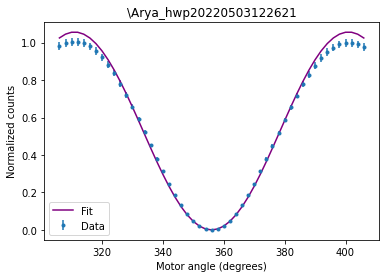

In [216]:
## Fitting the data
initial_guess=np.array([1, 0.24, 0, 0.00011, 37])
#bounds=((0,-10,0),(3,10,2.8623569275189746e-06))
bounds=((0, -5, 0, 0 ,-180),(4, 5, 2.8623569275189746e-06, 0.2, 180))
popt, pcov = curve_fit(f, xdata, ydata, p0=initial_guess, sigma=y_err, bounds=bounds)

fit_A = popt[0]
fit_B = popt[1]
fit_C = popt[2]
if type=='_i':
    fit_D = popt[3]
    fit_E = popt[4]

fit_y = f(xdata, fit_A, fit_B, fit_C, fit_D, fit_E)

plt.errorbar(angles_plot, ydata, yerr=y_err, fmt='.', label='Data')
plt.plot(angles_plot, fit_y, '-', label='Fit', color='purple')

plt.title(folder)
plt.xlabel("Motor angle (degrees)")
plt.ylabel("Normalized counts")
plt.legend()

print("param A: ", fit_A, "\pm", np.sqrt(pcov[0][0]))
print("param phi: ", fit_B, "\pm ", np.sqrt(pcov[1][1]))
print("param B: ", fit_C, "\pm ", np.sqrt(pcov[2][2]))
if type=='_i':
    print("param beta: ", fit_D, "\pm ", np.sqrt(pcov[3][3]))
    print("param p: ", fit_E, "\pm ", np.sqrt(pcov[4][4]))

print('\n 0 of the WP was: ', offset, 'and it should be: ', offset+fit_B)
print("Background should bebetween ", fit_A*0/np.mean(control_data), "and", fit_A*4/np.mean(control_data))

###### Using least sqares method!!
t=xdata
#Input polarization PERPENDICULAR to WPS
optimize_func_qwp_p = lambda x: x[0]*(2*(np.cos(np.pi*(t-x[1])/180)**2)*(np.sin(np.pi*(t-x[1])/180))**2+x[2])-ydata
optimize_func_hwp_p = lambda x: x[0]*(np.sin(2*np.pi*(t-x[1])/180)**2+x[2])-ydata
optimize_func_qwp_i = lambda x: x[0]*((x[3]+x[3]*np.cos(4*np.pi*(t-x[1])/180)+np.sin(2*np.pi*(t-x[1])/180)**2-np.sqrt((1-x[3])*x[3])*(np.cos(np.pi*x[4]/180)*np.sin(4*np.pi*(t-x[1])/180)+4*np.cos(np.pi*(t-x[1])/180)*np.sin(np.pi*(t-x[1])/180)*np.sin(np.pi*x[4]/180)))/2+x[2])-ydata
optimize_func_hwp_i = lambda x: x[0]*((1+(-1+2*x[3])*np.cos(4*np.pi*(t-x[1])/180)+2*np.sqrt((1-x[3])*x[3])*np.cos(np.pi*x[4]/180)*np.sin(4*np.pi*(t-x[1])/180))/2+x[2])-ydata

#bounds=((0,-180,0),(5,180,4.779021415595711e-06))
bounds=((0,-5,0, 0 ,-180),(5,5,4.779021415595711e-06, 0.2, 180))
type='_i'
f2='optimize_func_'+str(folder[-17:-14:1])+type

fit_A, fit_B, fit_C, fit_D, fit_E = least_squares(eval(f2), x0=[2, 0, 0, 0, 0], bounds=bounds)['x']
fit = f(xdata, fit_A, fit_B, fit_C, fit_D, fit_E)
plt.errorbar(angles_plot, ydata, yerr=y_err, fmt='.', label='Data')
plt.plot(angles_plot, fit, '-', label='Fit', color='purple')

plt.title(folder)
plt.xlabel("Motor angle (degrees)")
plt.ylabel("Normalized counts")
plt.legend()

print("param A: ", fit_A)#, "\pm", np.sqrt(pcov[0][0]))
print("param phi: ", fit_B)#, "\pm ", np.sqrt(pcov[1][1]))
print("param B: ", fit_C)#, "\pm ", np.sqrt(pcov[2][2]))
if type=='_i':
    print("param beta: ", fit_D)#, "\pm ", np.sqrt(pcov[3][3]))
    print("param p: ", fit_E)#, "\pm ", np.sqrt(pcov[4][4]))

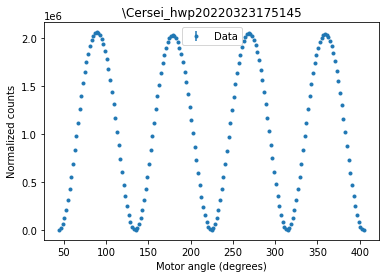

In [81]:
### Measuring the background
ydata = counts
y_err = np.sqrt(counts)
plt.errorbar(angles_plot, ydata, yerr=y_err, fmt='.', label='Data')
plt.title(folder)
plt.xlabel("Motor angle (degrees)")
plt.ylabel("Normalized counts")
plt.legend()

In [ ]:
maximum = qwp_cos(0,fit_A, fit_B, fit_C)
#maximum = np.max(counts)
theory = np.full(len(angles), maximum/2)
#plt.plot(angles_plot, theory, '-', label='Half maximum of fit', color='red')